<a href="https://colab.research.google.com/github/BlueBlazin/nlp_from_ground_up/blob/master/rnn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import pandas as pd
import plotly.express as px
import tensorflow_datasets as tfds

First, some basic functions.

In [2]:
def softmax(x):
    x -= np.max(x)
    x = np.exp(x)
    return x / np.sum(x)

In [3]:
def cross_entropy(t, pred):
    target = np.zeros_like(pred)
    target[t] = 1
    return -np.sum(target * np.log(pred))

In [4]:
def loss_fn(ts, ys):
    return sum(cross_entropy(t, y) for t, y in zip(ts, ys)) / len(ts)

The vanilla RNN is just $\mathbf{h_t} = \text{tanh}(\mathbf{W_x} \mathbf{x_t} + \mathbf{W_h} \mathbf{h_{t-1}} + \mathbf{b_h})$.

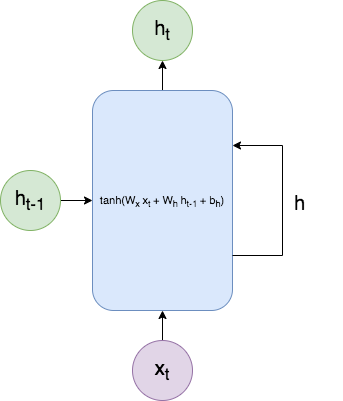

In [5]:
def rnn_cell(x, hprev, Wx, Wh, bh):
    return np.tanh(Wx @ x + Wh @ hprev + bh)

In [6]:
def forward_pass(xs, h, Wx, Wh, bh, Wy, by):
    hs = []
    ys = []

    for x in xs:
        h = rnn_cell(x, h, Wx, Wh, bh)
        hs.append(h)

        y = softmax(Wy @ h + by)
        ys.append(y)

    return ys, hs

#### Backward Pass

When it comes to writing backpropagation by hand it's helpful to be explicit by drawing the computation graph in steps of simple operations.

Note: If the emphasis is on simple operations, why the `cross_ent(softmax(r_t))` step? That's because that entire operation has a very simple gradient (explained below).

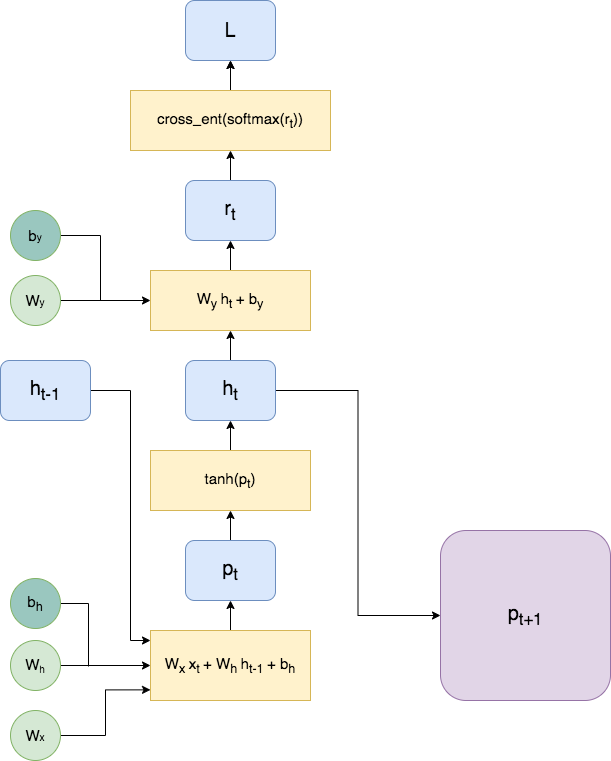

In [7]:
def backward_pass(xs, ys, hs, ts, Wy, by, Wx, Wh, bh):
    dWy = np.zeros_like(Wy)
    dby = np.zeros_like(by)

    dWx = np.zeros_like(Wx)

    dWh = np.zeros_like(Wh)
    dbh = np.zeros_like(bh)

    dpnext = np.zeros_like(hs[0])

    for t in reversed(range(len(ys))):
        y = ys[t]
        h = hs[t]
        x = xs[t]
        hprev = hs[t - 1]

        dr = y.copy()
        dr[ts[t]] -= 1

        dh = Wy.T @ dr + Wh @ dpnext

        dWy += dr @ h.T
        dby += dr

        dp = (1 - h * h) * dh

        dWx += dp @ x.T

        dWh += dp @ hprev.T
        dbh += dp

        dpnext = dp.copy()

    return dWy, dby, dWx, dWh, dbh

In [8]:
xs = [np.array([[1, 0, 0, 0]]).T, np.array([[0, 1, 0, 0]]).T, np.array([[0, 0, 1, 0]]).T]

ts = [1, 2, 3]

Wx = np.random.randn(3, 4)

Wh = np.random.randn(3, 3)
bh = np.random.randn(3, 1)

Wy = np.random.randn(4, 3)
by = np.random.randn(4, 1)

hzero = np.zeros((3, 1))

In [9]:
alpha = 0.01
losses = []

for i in range(5000):
    ys, hs = forward_pass(xs, hzero, Wx, Wh, bh, Wy, by)
    hs.append(hzero)

    losses.append(loss_fn(ts, ys))

    if i % 500 == 0:
        print(losses[-1])

    dWy, dby, dWx, dWh, dbh = backward_pass(xs, ys, hs, ts, Wy, by, Wx, Wh, bh)

    Wy -= alpha * dWy
    by -= alpha * dby

    Wx -= alpha * dWx

    Wh -= alpha * dWh
    bh -= alpha * dbh

1.784090671285244
0.11780330666876647
0.045998932257864215
0.0275541788732183
0.01954912148048346
0.015122104049302428
0.01231932579683521
0.010386157443867595
0.00897176490753679
0.007891399136122102


In [10]:
df = pd.DataFrame({'Epoch': range(len(losses)), 'Loss': losses})
fig = px.line(df, x="Epoch", y="Loss", title='Training loss')
fig.show()

In [11]:
dataset = tfds.load(name='tiny_shakespeare')['train']

In [12]:
def one_hot(k):
    enc = np.zeros((256, 1))
    enc[k, 0] = 1
    return enc

In [13]:
def xavier(shape):
    width = 1 / np.sqrt(shape[-1])
    return np.random.uniform(-width, width, size=shape)

In [14]:
hidden_dim = 64
vocab_size = 256
size = 25
alpha = 0.001
num_epochs = 5

In [15]:
Wx = xavier((hidden_dim, vocab_size))

Wh = xavier((hidden_dim, hidden_dim))
bh = xavier((hidden_dim, 1))

Wy = xavier((vocab_size, hidden_dim))
by = xavier((vocab_size, 1))

In [16]:
i = 0
losses = []

for epoch in range(num_epochs):
    for record in dataset.batch(1):
        line = list(record['text'].numpy()[0])

        hzero = np.zeros_like(bh)

        for t in range(0, len(line) - size - 1):
            xs = line[t:t + size]
            xs = [one_hot(k) for k in xs]

            ts = line[t + 1:t + size + 1]

            ys, hs = forward_pass(xs, hzero, Wx, Wh, bh, Wy, by)
            hs.append(hzero)

            if i % 1000 == 0:
                losses.append(loss_fn(ts, ys))
                print(f"Loss at step {i}: {losses[-1]}")

            dWy, dby, dWx, dWh, dbh = backward_pass(xs, ys, hs, ts, Wy, by, Wx, Wh, bh)

            Wy -= alpha * dWy
            by -= alpha * dby

            Wx -= alpha * dWx

            Wh -= alpha * dWh
            bh -= alpha * dbh

            hzero = hs[-2]  # the last h_t will be the next hzero
            i += 1

Loss at step 0: 5.963962409270957
Loss at step 1000: 3.4276743985981217
Loss at step 2000: 3.219122790234636
Loss at step 3000: 3.0893951471938226


KeyboardInterrupt: ignored

In [ ]:
df = pd.DataFrame({'Epoch': range(len(losses)),
                   'Loss': losses,
                   'Running Avg Loss': np.convolve(losses, np.ones(10)/10, mode='valid')})

fig = px.line(df, x="Step", y="Loss")
fig = px.line(df, x="Step", y="Running Avg Loss")
fig.show()

In [ ]:
h = np.zeros_like(bh)
sentence = ['T']
x = ord(sentence[0])

for _ in range(140):
    h = rnn_cell(one_hot(x), hzero, Wx, Wh, bh)
    y = Wy @ h + by

    x = np.argmax(y[:, 0])
    sentence.append(chr(x))

print("".join(sentence))